# VAE GRA v1: Complete Pipeline - Raw Data to UMAP Visualizations

This notebook implements the complete pipeline for the VAE lithology model using GRA + MS + NGR measurements.

**Model**: vae_gra_v1  
**Data**: 403,391 samples from 524 boreholes  
**Features**: 3D (GRA bulk density, Magnetic susceptibility, NGR counts)  
**Latent spaces**: 2D and 8D models  

## Pipeline Steps:
1. Load and explore raw training data
2. Preprocess features
3. Load trained VAE models
4. Generate latent representations
5. Create UMAP visualizations
6. Analyze clusters and lithology patterns

In [1]:
!uv remove umap
!uv add umap-learn

export: Command not found.
error: The dependency `umap` could not be found in `project.dependencies`
export: Command not found.
Resolved 175 packages in 1ms
Audited 170 packages in 0.06ms


In [2]:
# Import libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu128
CUDA available: True


## 1. Define VAE Model Architecture

In [3]:
class VAE(nn.Module):
    """Variational Autoencoder for lithology representation learning."""
    
    def __init__(self, input_dim=3, latent_dim=8, hidden_dims=[16, 8]):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.ReLU(),
                nn.BatchNorm1d(h_dim),
                nn.Dropout(0.1)
            ])
            prev_dim = h_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.ReLU(),
                nn.BatchNorm1d(h_dim),
                nn.Dropout(0.1)
            ])
            prev_dim = h_dim
        
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

print("VAE model architecture defined")

VAE model architecture defined


## 2. Load and Explore Raw Data

In [4]:
# Load training data
data_path = '/home/utig5/johna/bhai/vae_training_data_20cm.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nNumber of boreholes: {df['Borehole_ID'].nunique()}")
print(f"Number of unique lithologies: {df['Principal'].nunique()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (403391, 6)

Columns: ['Borehole_ID', 'Depth_Bin', 'Principal', 'Bulk density (GRA)', 'Magnetic susceptibility (instr. units)', 'NGR total counts (cps)']

Number of boreholes: 524
Number of unique lithologies: 178

First few rows:


,Borehole_ID,Depth_Bin,Principal,Bulk density (GRA),Magnetic susceptibility (instr. units),NGR total counts (cps)
0,318-U1355A,0.0,sand,1.521400,221.2500,32.2385
1,318-U1355A,0.2,sand,1.501143,456.0750,32.6425
2,318-U1355A,0.4,sand,1.557750,676.2000,36.7370
3,318-U1355A,0.6,sand,1.695875,800.2500,38.4190
4,318-U1355A,0.8,sand,1.790625,742.8875,38.5345


In [5]:
# Feature statistics
feature_cols = [
    'Bulk density (GRA)',
    'Magnetic susceptibility (instr. units)',
    'NGR total counts (cps)'
]

print("Feature Statistics:")
print("="*60)
df[feature_cols].describe()

Feature Statistics:


,Bulk density (GRA),Magnetic susceptibility (instr. units),NGR total counts (cps)
count,403391.000000,403391.000000,403391.000000
mean,1.669775,107.683318,25.334525
std,0.271777,349.497902,17.973188
min,-2.387750,-479.677500,-5.885000
25%,1.530437,4.041667,11.279167
50%,1.695000,16.412500,23.177000
75%,1.838667,55.250312,35.959583
max,8.462000,8964.699500,292.543500


In [6]:
# Lithology distribution
print("\nTop 15 Lithologies:")
print("="*60)
top_lithologies = df['Principal'].value_counts().head(15)
for lith, count in top_lithologies.items():
    pct = count / len(df) * 100
    print(f"{lith:30s}: {count:6d} ({pct:5.2f}%)")


Top 15 Lithologies:
nannofossil ooze              :  79938 (19.82%)
clay                          :  47906 (11.88%)
silty clay                    :  31332 ( 7.77%)
mud                           :  24105 ( 5.98%)
diatom ooze                   :  17935 ( 4.45%)
nannofossil chalk             :  16013 ( 3.97%)
wackestone                    :  15017 ( 3.72%)
packstone                     :  14436 ( 3.58%)
clayey silt                   :  11513 ( 2.85%)
mudstone                      :  10741 ( 2.66%)
sand                          :  10501 ( 2.60%)
claystone                     :  10260 ( 2.54%)
nannofossil clay              :   8561 ( 2.12%)
basalt                        :   6738 ( 1.67%)
nannofossil mud               :   5948 ( 1.47%)


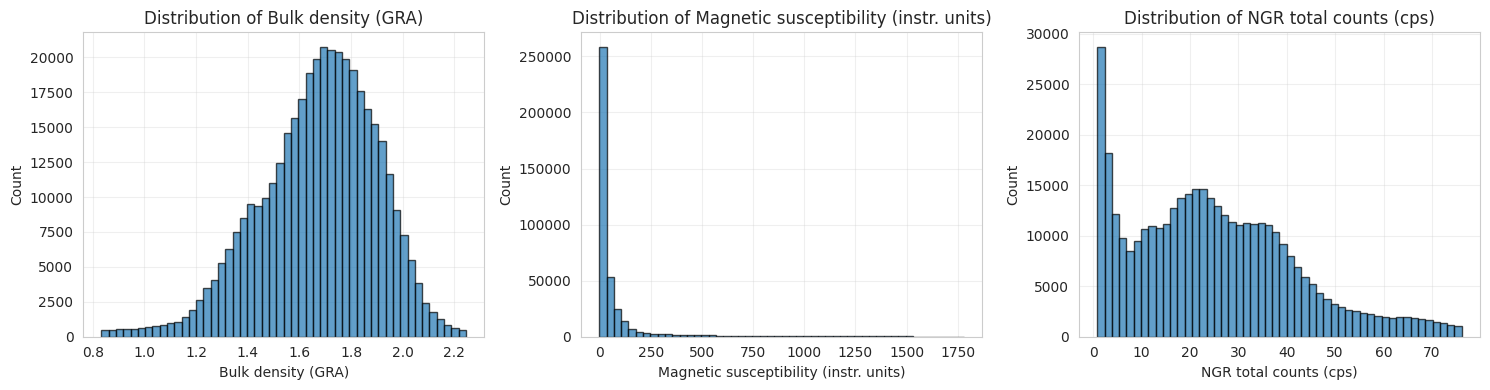

In [7]:
# Visualize feature distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, feature_cols):
    # Remove outliers for better visualization
    data = df[col].dropna()
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]
    
    ax.hist(data_filtered, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Preprocess Data

In [8]:
# Extract features and labels
X = df[feature_cols].values
lithology = df['Principal'].values
borehole_ids = df['Borehole_ID'].values

# Remove NaN values
valid_mask = ~np.isnan(X).any(axis=1)
X = X[valid_mask]
lithology = lithology[valid_mask]
borehole_ids = borehole_ids[valid_mask]

print(f"Valid samples: {len(X):,}")
print(f"Feature matrix shape: {X.shape}")

Valid samples: 403,391
Feature matrix shape: (403391, 3)


In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized (mean=0, std=1)")
print(f"\nMean: {X_scaled.mean(axis=0)}")
print(f"Std:  {X_scaled.std(axis=0)}")

Features standardized (mean=0, std=1)

Mean: [-7.28504197e-14  4.04554732e-14  1.71174196e-14]
Std:  [1. 1. 1.]


## 4. Load Trained VAE Models

In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load models
checkpoint_dir = Path('/home/utig5/johna/bhai/ml_models/checkpoints')

# Load 2D model
checkpoint_2d = torch.load(checkpoint_dir / 'vae_gra_latent2.pth', map_location=device, weights_only=False)
model_2d = VAE(input_dim=3, latent_dim=2, hidden_dims=[16, 8]).to(device)
model_2d.load_state_dict(checkpoint_2d['model_state_dict'])
model_2d.eval()
print("✓ Loaded 2D latent VAE model")

# Load 8D model
checkpoint_8d = torch.load(checkpoint_dir / 'vae_gra_latent8.pth', map_location=device, weights_only=False)
model_8d = VAE(input_dim=3, latent_dim=8, hidden_dims=[16, 8]).to(device)
model_8d.load_state_dict(checkpoint_8d['model_state_dict'])
model_8d.eval()
print("✓ Loaded 8D latent VAE model")

# Use scaler from checkpoint (should be same as our fitted one)
scaler_checkpoint = checkpoint_2d['scaler']
print("\n✓ Models loaded and ready for inference")

Using device: cuda
✓ Loaded 2D latent VAE model
✓ Loaded 8D latent VAE model

✓ Models loaded and ready for inference


## 5. Generate Latent Representations

In [11]:
def get_latent_representations(model, data, batch_size=1024, device='cuda'):
    """Extract latent representations from VAE model."""
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            mu, _ = model.encode(batch_tensor)
            latent_vectors.append(mu.cpu().numpy())
    
    return np.vstack(latent_vectors)

# Generate latent representations
print("Generating latent representations...")
latent_2d = get_latent_representations(model_2d, X_scaled, device=device)
print(f"✓ 2D latent space: {latent_2d.shape}")

latent_8d = get_latent_representations(model_8d, X_scaled, device=device)
print(f"✓ 8D latent space: {latent_8d.shape}")

Generating latent representations...
✓ 2D latent space: (403391, 2)
✓ 8D latent space: (403391, 8)


## 6. UMAP Projections

In [12]:
# 2D latent space is already 2D, so we can visualize directly
# For 8D, we'll use UMAP to project to 2D

print("Computing UMAP projection for 8D latent space...")
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    verbose=True
)

# Sample data for faster UMAP computation if dataset is large
n_samples = len(latent_8d)
if n_samples > 50000:
    print(f"Sampling {50000} points for UMAP computation...")
    sample_idx = np.random.choice(n_samples, 50000, replace=False)
    latent_8d_sample = latent_8d[sample_idx]
    lithology_sample = lithology[sample_idx]
else:
    latent_8d_sample = latent_8d
    lithology_sample = lithology
    sample_idx = np.arange(n_samples)

latent_8d_umap = umap_model.fit_transform(latent_8d_sample)
print(f"✓ UMAP projection complete: {latent_8d_umap.shape}")

Computing UMAP projection for 8D latent space...
Sampling 50000 points for UMAP computation...
UMAP(n_jobs=1, random_state=42, verbose=True)
Fri Oct 17 06:37:49 2025 Construct fuzzy simplicial set
Fri Oct 17 06:37:49 2025 Finding Nearest Neighbors
Fri Oct 17 06:37:49 2025 Building RP forest with 16 trees
Fri Oct 17 06:37:54 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Fri Oct 17 06:38:06 2025 Finished Nearest Neighbor Search
Fri Oct 17 06:38:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Oct 17 06:38:59 2025 Finished embedding
✓ UMAP projection complete: (50000, 2)


## 7. Visualizations

In [13]:
# Get top lithologies for coloring
top_n = 10
top_lithologies = pd.Series(lithology).value_counts().head(top_n).index.tolist()

def get_lithology_colors(lithology_array, top_lithologies):
    """Assign colors to lithologies."""
    colors = []
    for lith in lithology_array:
        if lith in top_lithologies:
            colors.append(top_lithologies.index(lith))
        else:
            colors.append(top_n)  # 'Other' category
    return np.array(colors)

# Prepare color palette
palette = sns.color_palette('tab10', top_n)
palette.append((0.7, 0.7, 0.7))  # Gray for 'Other'
lithology_labels = top_lithologies + ['Other']

print(f"Color coding by top {top_n} lithologies:")
for i, lith in enumerate(lithology_labels):
    count = (lithology == lith).sum() if lith != 'Other' else ((~np.isin(lithology, top_lithologies)).sum())
    print(f"  {i}: {lith} (n={count:,})")

Color coding by top 10 lithologies:
  0: nannofossil ooze (n=79,938)
  1: clay (n=47,906)
  2: silty clay (n=31,332)
  3: mud (n=24,105)
  4: diatom ooze (n=17,935)
  5: nannofossil chalk (n=16,013)
  6: wackestone (n=15,017)
  7: packstone (n=14,436)
  8: clayey silt (n=11,513)
  9: mudstone (n=10,741)
  10: Other (n=134,455)


### 7.1 Direct 2D Latent Space Visualization

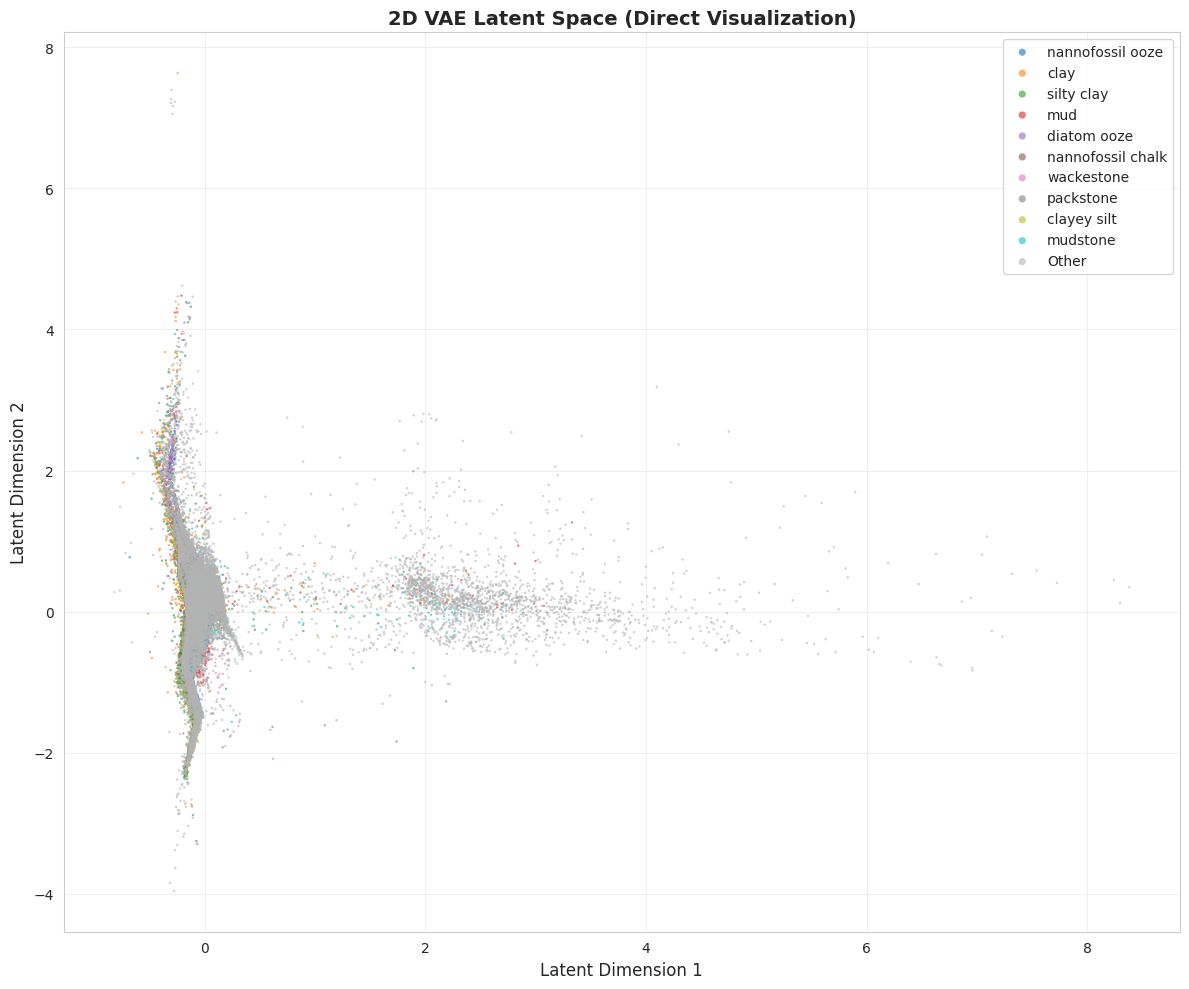

✓ Saved: vae_outputs/latent_2d_direct.png


In [14]:
# Sample for visualization (too many points can be slow)
n_vis = min(50000, len(latent_2d))
vis_idx = np.random.choice(len(latent_2d), n_vis, replace=False)

latent_2d_vis = latent_2d[vis_idx]
lithology_vis = lithology[vis_idx]
colors_2d = get_lithology_colors(lithology_vis, top_lithologies)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each lithology
for i, (lith, color) in enumerate(zip(lithology_labels, palette)):
    mask = colors_2d == i
    if mask.sum() > 0:
        ax.scatter(
            latent_2d_vis[mask, 0],
            latent_2d_vis[mask, 1],
            c=[color],
            label=lith,
            alpha=0.6,
            s=3,
            edgecolors='none'
        )

ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.set_title('2D VAE Latent Space (Direct Visualization)', fontsize=14, fontweight='bold')
ax.legend(markerscale=3, fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/utig5/johna/bhai/vae_outputs/latent_2d_direct.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: vae_outputs/latent_2d_direct.png")

### 7.2 UMAP Projection of 8D Latent Space

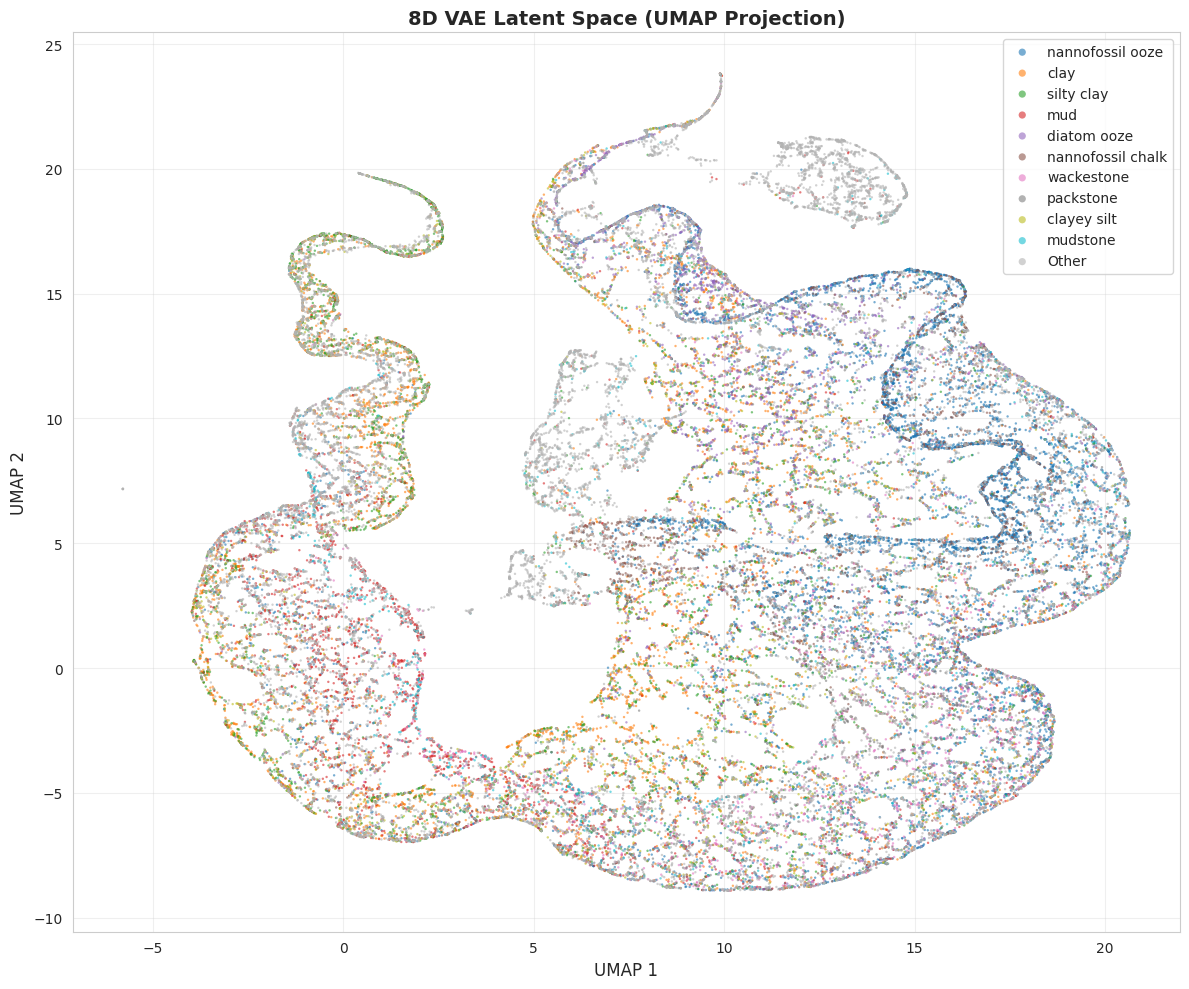

✓ Saved: vae_outputs/latent_8d_umap.png


In [15]:
# Prepare colors for sampled data
colors_8d = get_lithology_colors(lithology_sample, top_lithologies)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each lithology
for i, (lith, color) in enumerate(zip(lithology_labels, palette)):
    mask = colors_8d == i
    if mask.sum() > 0:
        ax.scatter(
            latent_8d_umap[mask, 0],
            latent_8d_umap[mask, 1],
            c=[color],
            label=lith,
            alpha=0.6,
            s=3,
            edgecolors='none'
        )

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('8D VAE Latent Space (UMAP Projection)', fontsize=14, fontweight='bold')
ax.legend(markerscale=3, fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/utig5/johna/bhai/vae_outputs/latent_8d_umap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: vae_outputs/latent_8d_umap.png")

### 7.3 Side-by-Side Comparison

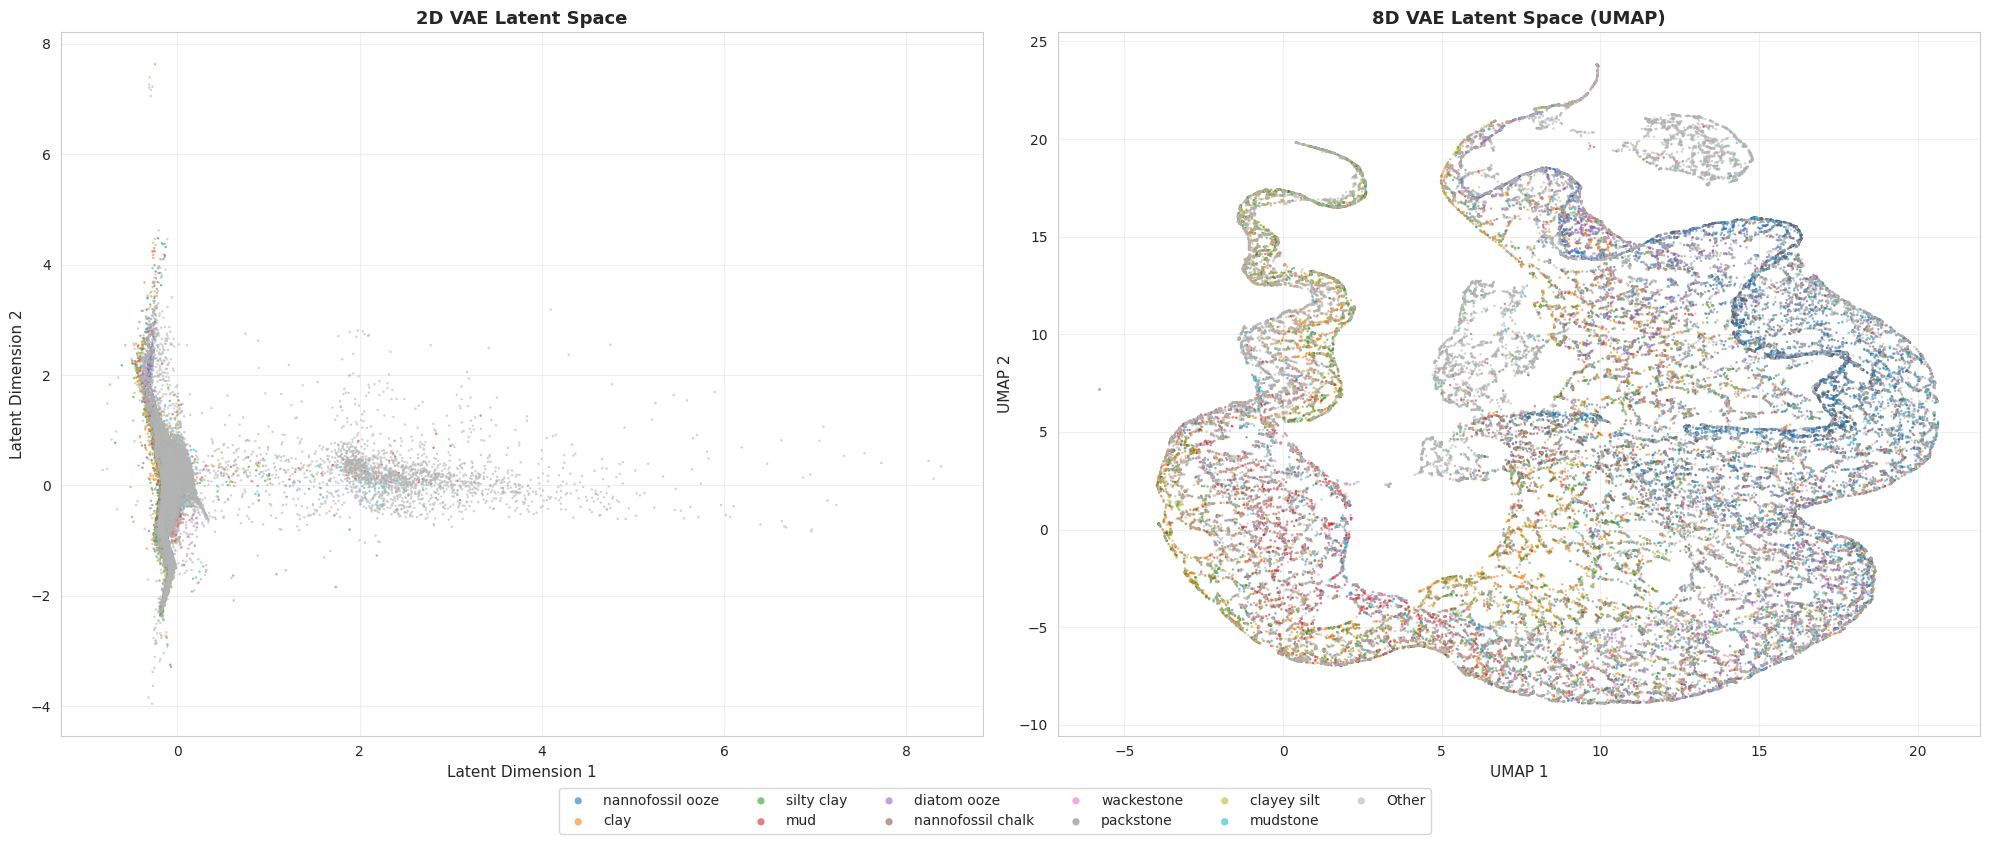

✓ Saved: vae_outputs/latent_comparison.png


In [16]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: 2D latent space
ax = axes[0]
for i, (lith, color) in enumerate(zip(lithology_labels, palette)):
    mask = colors_2d == i
    if mask.sum() > 0:
        ax.scatter(
            latent_2d_vis[mask, 0],
            latent_2d_vis[mask, 1],
            c=[color],
            label=lith,
            alpha=0.6,
            s=3,
            edgecolors='none'
        )
ax.set_xlabel('Latent Dimension 1', fontsize=11)
ax.set_ylabel('Latent Dimension 2', fontsize=11)
ax.set_title('2D VAE Latent Space', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Right: 8D UMAP projection
ax = axes[1]
for i, (lith, color) in enumerate(zip(lithology_labels, palette)):
    mask = colors_8d == i
    if mask.sum() > 0:
        ax.scatter(
            latent_8d_umap[mask, 0],
            latent_8d_umap[mask, 1],
            c=[color],
            label=lith,
            alpha=0.6,
            s=3,
            edgecolors='none'
        )
ax.set_xlabel('UMAP 1', fontsize=11)
ax.set_ylabel('UMAP 2', fontsize=11)
ax.set_title('8D VAE Latent Space (UMAP)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=6, markerscale=3, fontsize=10)

plt.tight_layout()
plt.savefig('/home/utig5/johna/bhai/vae_outputs/latent_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: vae_outputs/latent_comparison.png")

## 8. K-Means Clustering Analysis

In [17]:
# Perform clustering on 8D latent space
n_clusters = 10
print(f"Performing K-Means clustering with k={n_clusters}...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_8d_sample)

print("\nCluster Analysis:")
print("="*80)
for cluster_id in range(n_clusters):
    mask = cluster_labels == cluster_id
    cluster_lithologies = lithology_sample[mask]
    cluster_size = len(cluster_lithologies)
    
    if cluster_size > 0:
        top_3 = Counter(cluster_lithologies).most_common(3)
        top_lith, top_count = top_3[0]
        top_pct = top_count / cluster_size * 100
        
        print(f"Cluster {cluster_id:2d} (n={cluster_size:6d}): {top_lith:30s} ({top_pct:5.1f}%)")
        for lith, count in top_3[1:]:
            pct = count / cluster_size * 100
            print(f"{'':38s} {lith:30s} ({pct:5.1f}%)")

Performing K-Means clustering with k=10...

Cluster Analysis:
Cluster  0 (n= 11625): nannofossil ooze               ( 19.3%)
                                       clay                           ( 13.0%)
                                       wackestone                     (  9.7%)
Cluster  1 (n=  4079): clay                           ( 18.9%)
                                       silty clay                     ( 11.2%)
                                       mud                            (  9.0%)
Cluster  2 (n= 10097): nannofossil ooze               ( 30.9%)
                                       clay                           ( 11.6%)
                                       diatom ooze                    ( 10.9%)
Cluster  3 (n=  1285): sand                           ( 22.2%)
                                       basalt                         ( 19.0%)
                                       carbonate ooze                 (  8.3%)
Cluster  4 (n=  7576): mud                            

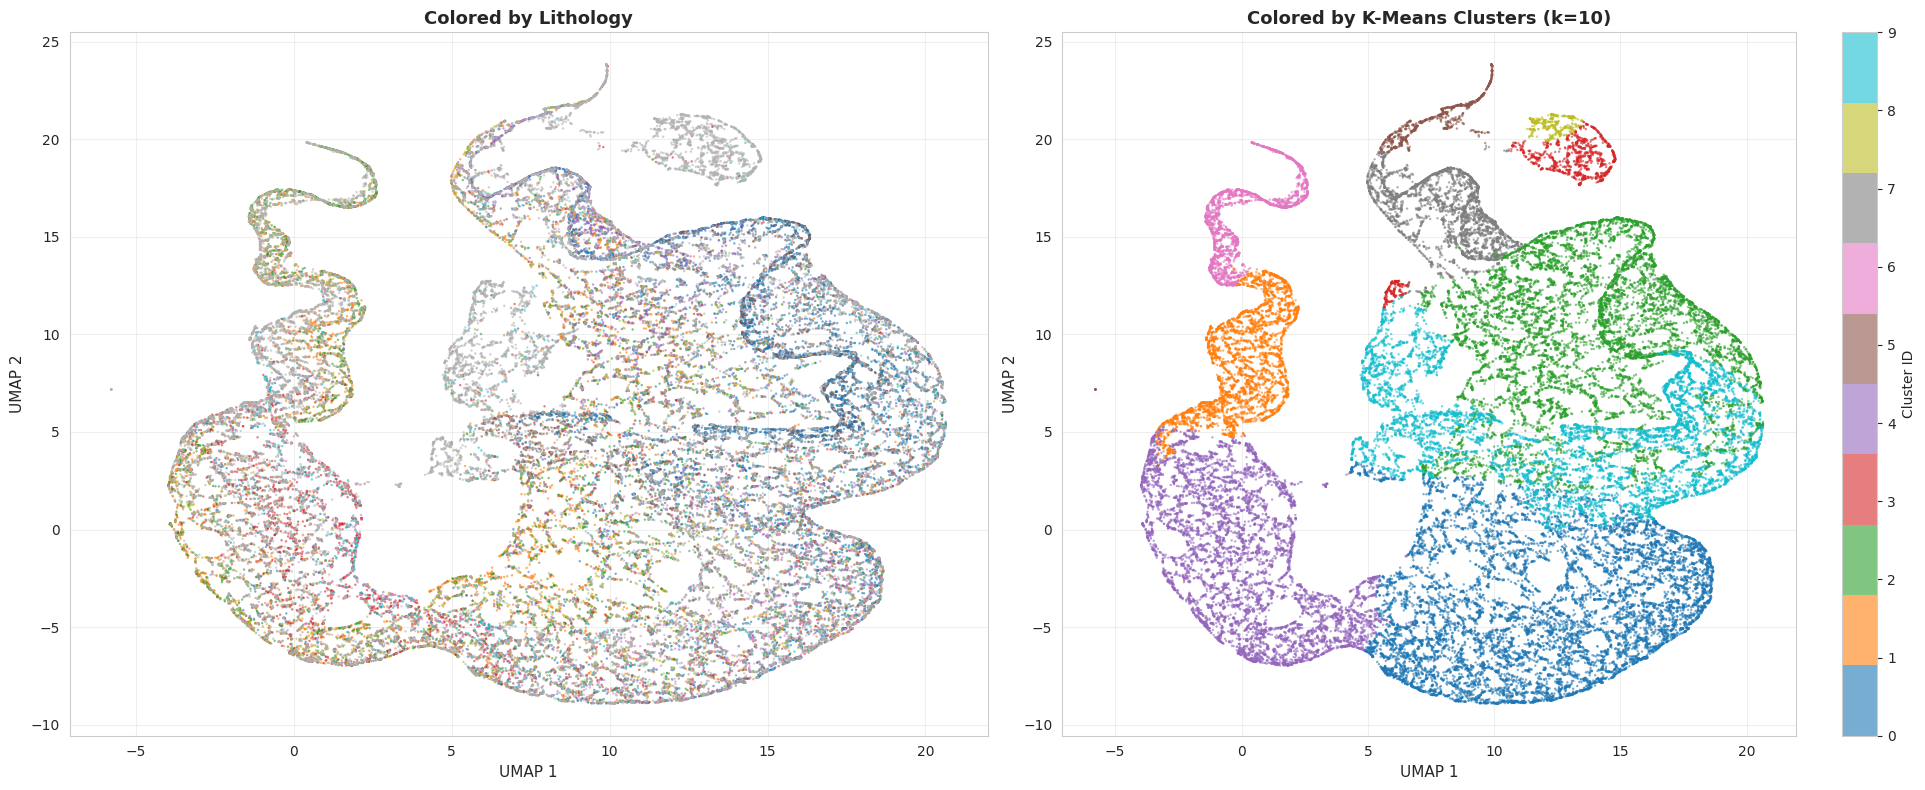

✓ Saved: vae_outputs/latent_8d_clusters.png


In [18]:
# Visualize clusters on UMAP projection
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: colored by lithology
ax = axes[0]
for i, (lith, color) in enumerate(zip(lithology_labels, palette)):
    mask = colors_8d == i
    if mask.sum() > 0:
        ax.scatter(
            latent_8d_umap[mask, 0],
            latent_8d_umap[mask, 1],
            c=[color],
            label=lith,
            alpha=0.6,
            s=3,
            edgecolors='none'
        )
ax.set_xlabel('UMAP 1', fontsize=11)
ax.set_ylabel('UMAP 2', fontsize=11)
ax.set_title('Colored by Lithology', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Right: colored by cluster
ax = axes[1]
scatter = ax.scatter(
    latent_8d_umap[:, 0],
    latent_8d_umap[:, 1],
    c=cluster_labels,
    cmap='tab10',
    alpha=0.6,
    s=3,
    edgecolors='none'
)
ax.set_xlabel('UMAP 1', fontsize=11)
ax.set_ylabel('UMAP 2', fontsize=11)
ax.set_title(f'Colored by K-Means Clusters (k={n_clusters})', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster ID', fontsize=10)

plt.tight_layout()
plt.savefig('/home/utig5/johna/bhai/vae_outputs/latent_8d_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: vae_outputs/latent_8d_clusters.png")

## 9. Reconstruction Quality

In [19]:
# Test reconstruction quality on a sample
n_test = 1000
test_idx = np.random.choice(len(X_scaled), n_test, replace=False)
X_test = X_scaled[test_idx]

# Reconstruct with 8D model
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    X_recon, mu, logvar = model_8d(X_test_tensor)
    X_recon = X_recon.cpu().numpy()

# Inverse transform to original scale
X_test_original = scaler_checkpoint.inverse_transform(X_test)
X_recon_original = scaler_checkpoint.inverse_transform(X_recon)

# Calculate reconstruction errors
print("Reconstruction Quality (8D VAE):")
print("="*60)
for i, feature in enumerate(feature_cols):
    mse = np.mean((X_test_original[:, i] - X_recon_original[:, i])**2)
    mae = np.mean(np.abs(X_test_original[:, i] - X_recon_original[:, i]))
    mape = np.mean(np.abs((X_test_original[:, i] - X_recon_original[:, i]) / X_test_original[:, i])) * 100
    
    print(f"{feature:45s}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print()

Reconstruction Quality (8D VAE):
Bulk density (GRA)                           
  MSE:  0.0367
  MAE:  0.1489
  MAPE: 10.15%

Magnetic susceptibility (instr. units)       
  MSE:  28678.3161
  MAE:  89.5623
  MAPE: inf%

NGR total counts (cps)                       
  MSE:  154.2490
  MAE:  10.0302
  MAPE: 199.29%



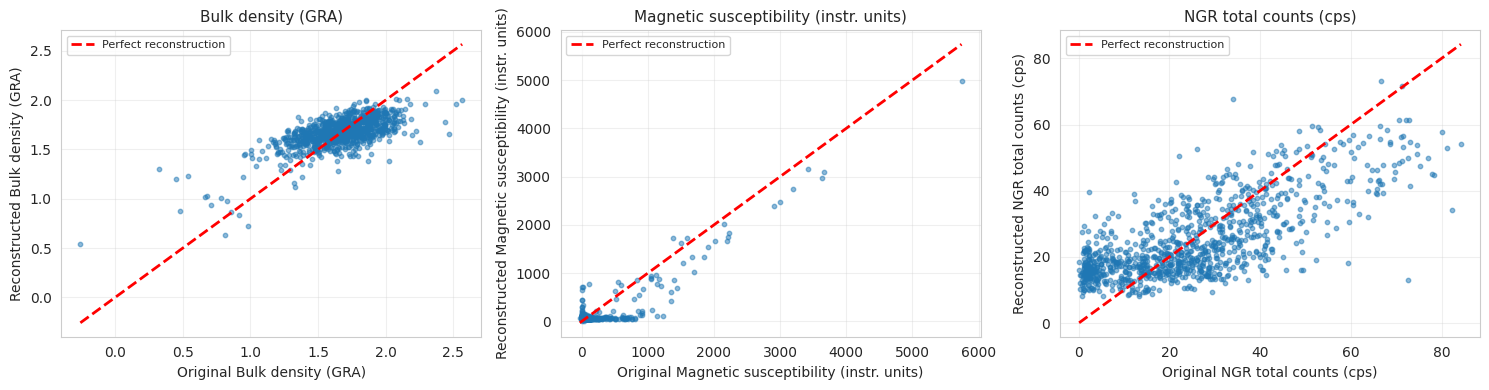

✓ Saved: vae_outputs/reconstruction_quality.png


In [20]:
# Visualize reconstruction
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (ax, feature) in enumerate(zip(axes, feature_cols)):
    ax.scatter(X_test_original[:, i], X_recon_original[:, i], alpha=0.5, s=10)
    
    # Plot perfect reconstruction line
    min_val = min(X_test_original[:, i].min(), X_recon_original[:, i].min())
    max_val = max(X_test_original[:, i].max(), X_recon_original[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect reconstruction')
    
    ax.set_xlabel(f'Original {feature}', fontsize=10)
    ax.set_ylabel(f'Reconstructed {feature}', fontsize=10)
    ax.set_title(feature, fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/utig5/johna/bhai/vae_outputs/reconstruction_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: vae_outputs/reconstruction_quality.png")

## 10. Summary Statistics

In [21]:
print("\n" + "="*80)
print("PIPELINE SUMMARY")
print("="*80)
print(f"\nDataset:")
print(f"  Total samples:        {len(X):,}")
print(f"  Number of boreholes:  {len(np.unique(borehole_ids))}")
print(f"  Unique lithologies:   {len(np.unique(lithology))}")
print(f"\nModels:")
print(f"  2D VAE latent space:  {latent_2d.shape}")
print(f"  8D VAE latent space:  {latent_8d.shape}")
print(f"\nVisualizations created:")
print(f"  ✓ latent_2d_direct.png      - Direct 2D latent space")
print(f"  ✓ latent_8d_umap.png        - UMAP projection of 8D space")
print(f"  ✓ latent_comparison.png     - Side-by-side comparison")
print(f"  ✓ latent_8d_clusters.png    - K-Means clustering visualization")
print(f"  ✓ reconstruction_quality.png - VAE reconstruction quality")
print(f"\nAll outputs saved to: /home/utig5/johna/bhai/vae_outputs/")
print("="*80)


PIPELINE SUMMARY

Dataset:
  Total samples:        403,391
  Number of boreholes:  524
  Unique lithologies:   178

Models:
  2D VAE latent space:  (403391, 2)
  8D VAE latent space:  (403391, 8)

Visualizations created:
  ✓ latent_2d_direct.png      - Direct 2D latent space
  ✓ latent_8d_umap.png        - UMAP projection of 8D space
  ✓ latent_comparison.png     - Side-by-side comparison
  ✓ latent_8d_clusters.png    - K-Means clustering visualization
  ✓ reconstruction_quality.png - VAE reconstruction quality

All outputs saved to: /home/utig5/johna/bhai/vae_outputs/
